In [1]:
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.layers import (Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, LeakyReLU,
                          Dropout, Flatten, Reshape, Lambda, MaxPool2D, Concatenate, add, Cropping2D)
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from math import log2

In [25]:
# Константы
img_side = 192

# Разбиваем датасет на тренировочную группу и группу валидации
def init_data_with_batch_size(batch_size):
    global train_data
    train_data = tf.keras.utils.image_dataset_from_directory(
        "new_flowers",
        image_size=(img_side, img_side),
        shuffle=True,
        batch_size=batch_size,
    )

    # Убираем лейблы (т.к. у нас задача не распознавать изображения)
    train_data = train_data.map(lambda x, y: (x/255.0, x/255.0))

    return train_data

Модель

In [3]:
# Константы
filters = 32
hidden_units = 256  # Только степень 4 (4**?) (Размер "смыслового вектора")
amount_encode_layers = 2
amount_decode_layers = 3
max_boudle_residual_layers = 2  # Сколько слоёв с остаточноым обучением перед уменьшением/увеличением картинки
"""
filters                     Слабое  влияние на количество параметров
hidden_units                Никакое влияние на количество параметров
amount_encode_layers        Сильное влияние на количество параметров
amount_decode_layers        Сильное влияние на количество параметров
max_boudle_residual_layers  Слабое  влияние на количество параметров
"""

core_size = (3, 3)
input_img = Input(shape=(img_side, img_side, 3))

"""Энкодер"""
# Это надо чтобы первый слой мог сложиться со следующим (при помощи add([x_temp, x]) )
# (momentum - параметр расчета скользящего среднего и дисперсии)
x_temp = BatchNormalization(momentum=0.9)(input_img)
x_temp = Conv2D(filters//2**amount_encode_layers, core_size, activation=LeakyReLU(0.1), padding="same")(x_temp)

for i in range(amount_encode_layers, -1, -1):
    for _ in range(max_boudle_residual_layers):
        x = Conv2D(filters // 2**i, core_size, activation=LeakyReLU(0.1), padding="same")(x_temp)
        x = Conv2D(filters // 2**i, core_size, activation=LeakyReLU(0.1), padding="same")(x)
        x_temp = add([x_temp, x])

    x_temp = MaxPool2D((2, 2))(x_temp)
    x_temp = Conv2D(filters // 2**(i - 1), core_size, activation=LeakyReLU(0.1), padding="same")(x_temp)
    x_temp = BatchNormalization(momentum=0.9)(x_temp)

# Чтобы фильтров было меньше и на сжимающий слой
x_temp = Conv2D(filters, core_size, activation=LeakyReLU(0.1), padding="same")(x_temp)


# Превращаем сжатую картинку в "смысловой вектор"
x = Flatten()(x_temp)
x = Dense(hidden_units, activation=LeakyReLU(0.1))(x)
x = Reshape((int(hidden_units**.5), int(hidden_units**.5), 1))(x)
x = BatchNormalization(momentum=0.9)(x)


"""Декодер"""
# Расширяем карту признаков, увеличиваем картинку, и остаточное обучение
for i in range(amount_decode_layers):
    for _ in range(max_boudle_residual_layers):
        x = Conv2DTranspose(filters, core_size, activation=LeakyReLU(0.1), padding="same")(x_temp)
        x = Conv2DTranspose(filters, core_size, activation=LeakyReLU(0.1), padding="same")(x)
        x_temp = add([x_temp, x])

    x_temp = Conv2DTranspose(filters, core_size, activation=LeakyReLU(0.1), padding="same", strides=2)(x_temp)
    x_temp = BatchNormalization(momentum=0.9)(x_temp)

# Просто добавляем признаки, не меняя картинку, но уменьшая колчество фильтров до 1
# (чтобы в Dense поступало не так много данных)
for i in range(int(log2(filters))):
    for _ in range(max_boudle_residual_layers):
        x = Conv2DTranspose(filters // 2**i, core_size, activation=LeakyReLU(0.1), padding="same")(x_temp)
        x = Conv2DTranspose(filters // 2**i, core_size, activation=LeakyReLU(0.1), padding="same")(x)
        x_temp = add([x_temp, x])

    # Чтобы количество фильтров совпадало (для остаточного обучения)
    x_temp = Conv2DTranspose(filters // 2**(i +1), core_size, activation=LeakyReLU(0.1), padding="same")(x_temp)
    x_temp = BatchNormalization(momentum=0.9)(x_temp)

# Добавляем цвета
x = BatchNormalization(momentum=0.9)(x)
x_temp = Conv2D(3, core_size, activation="sigmoid", padding="same")(x)
for _ in range(max_boudle_residual_layers):
    x = Conv2D(3, core_size, activation="sigmoid", padding="same")(x_temp)
    x = Conv2D(3, core_size, activation="sigmoid", padding="same")(x)
    x_temp = add([x_temp, x])

output_img = Reshape((img_side, img_side, 3))(x)

# Модель (ебать, я тут до 125 слоёв делал, и оно работало!)
vae = Model(input_img, output_img, name="vae")
vae.compile(
    optimizer=keras.optimizers.Adam(2e-3),
    loss="binary_crossentropy",
    loss_weights=[1000],
)

vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 192, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 192, 192, 16  448         ['batch_normalization[0][0]']    
                                )                                                               

In [32]:
train_data = init_data_with_batch_size(6)
vae.fit(
    train_data,
    epochs=2,
)

Found 37728 files belonging to 5 classes.
Epoch 1/2
 657/6288 [==>...........................] - ETA: 52:09 - loss: 513.3224

KeyboardInterrupt: 

Found 37728 files belonging to 5 classes.


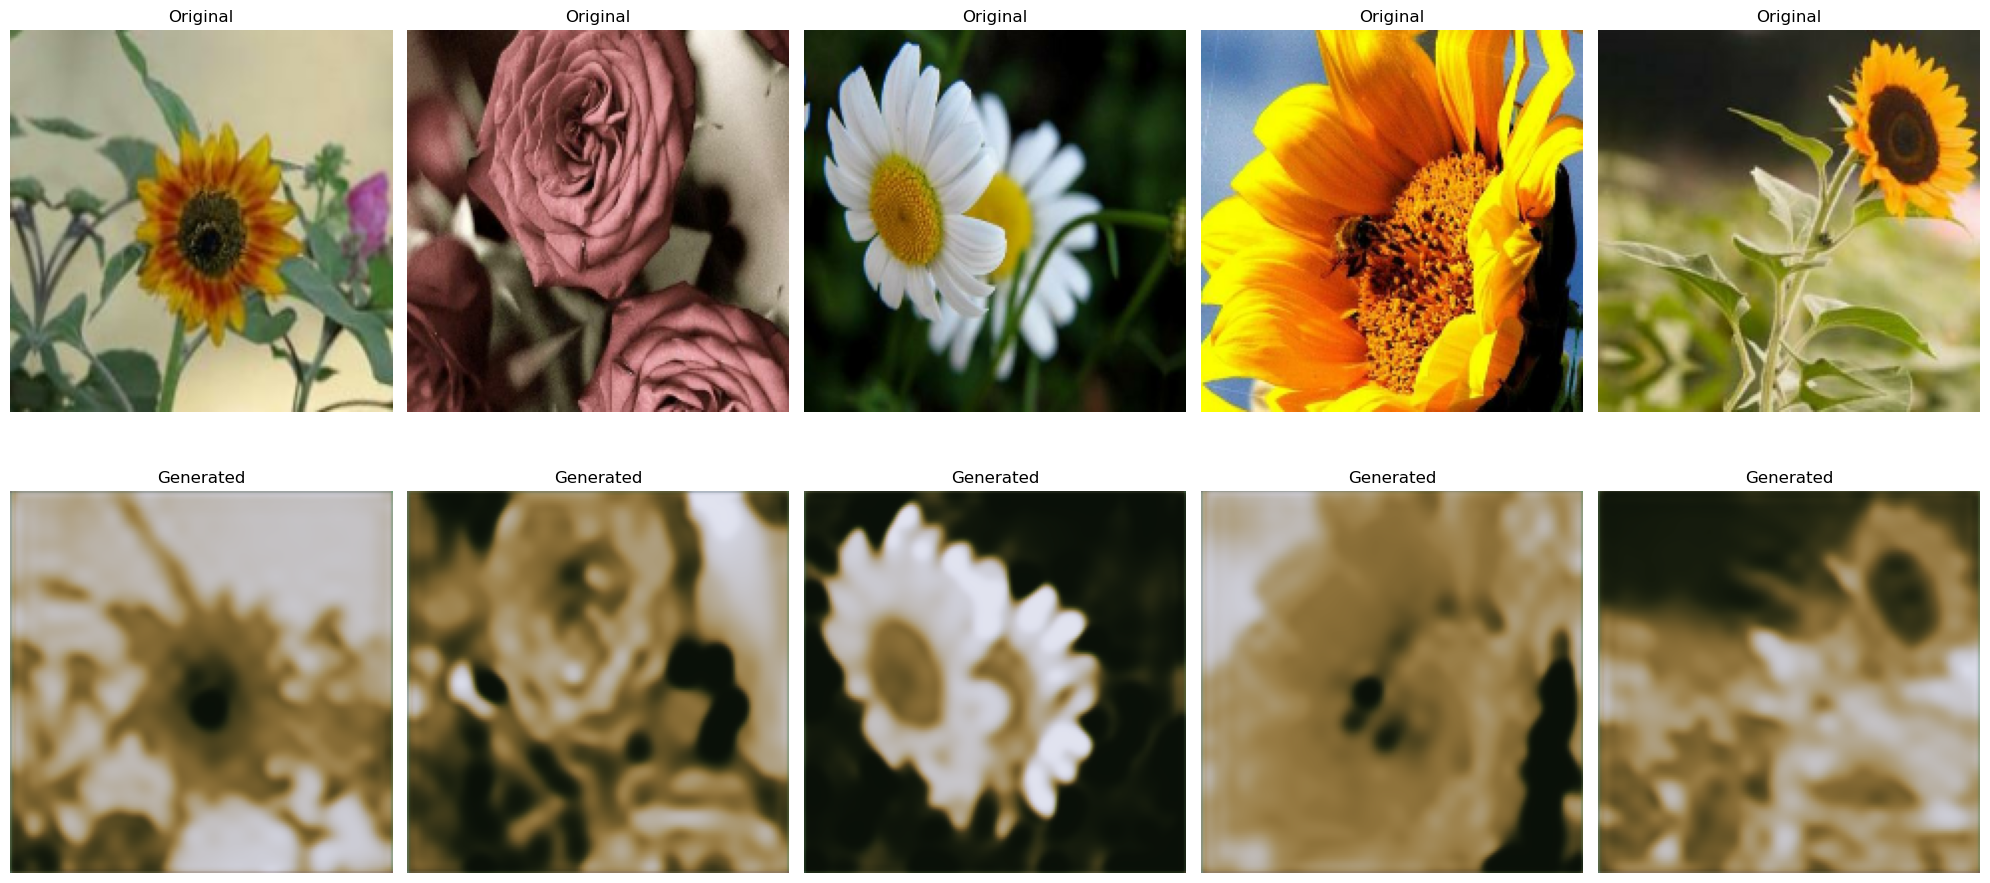

Found 37728 files belonging to 5 classes.


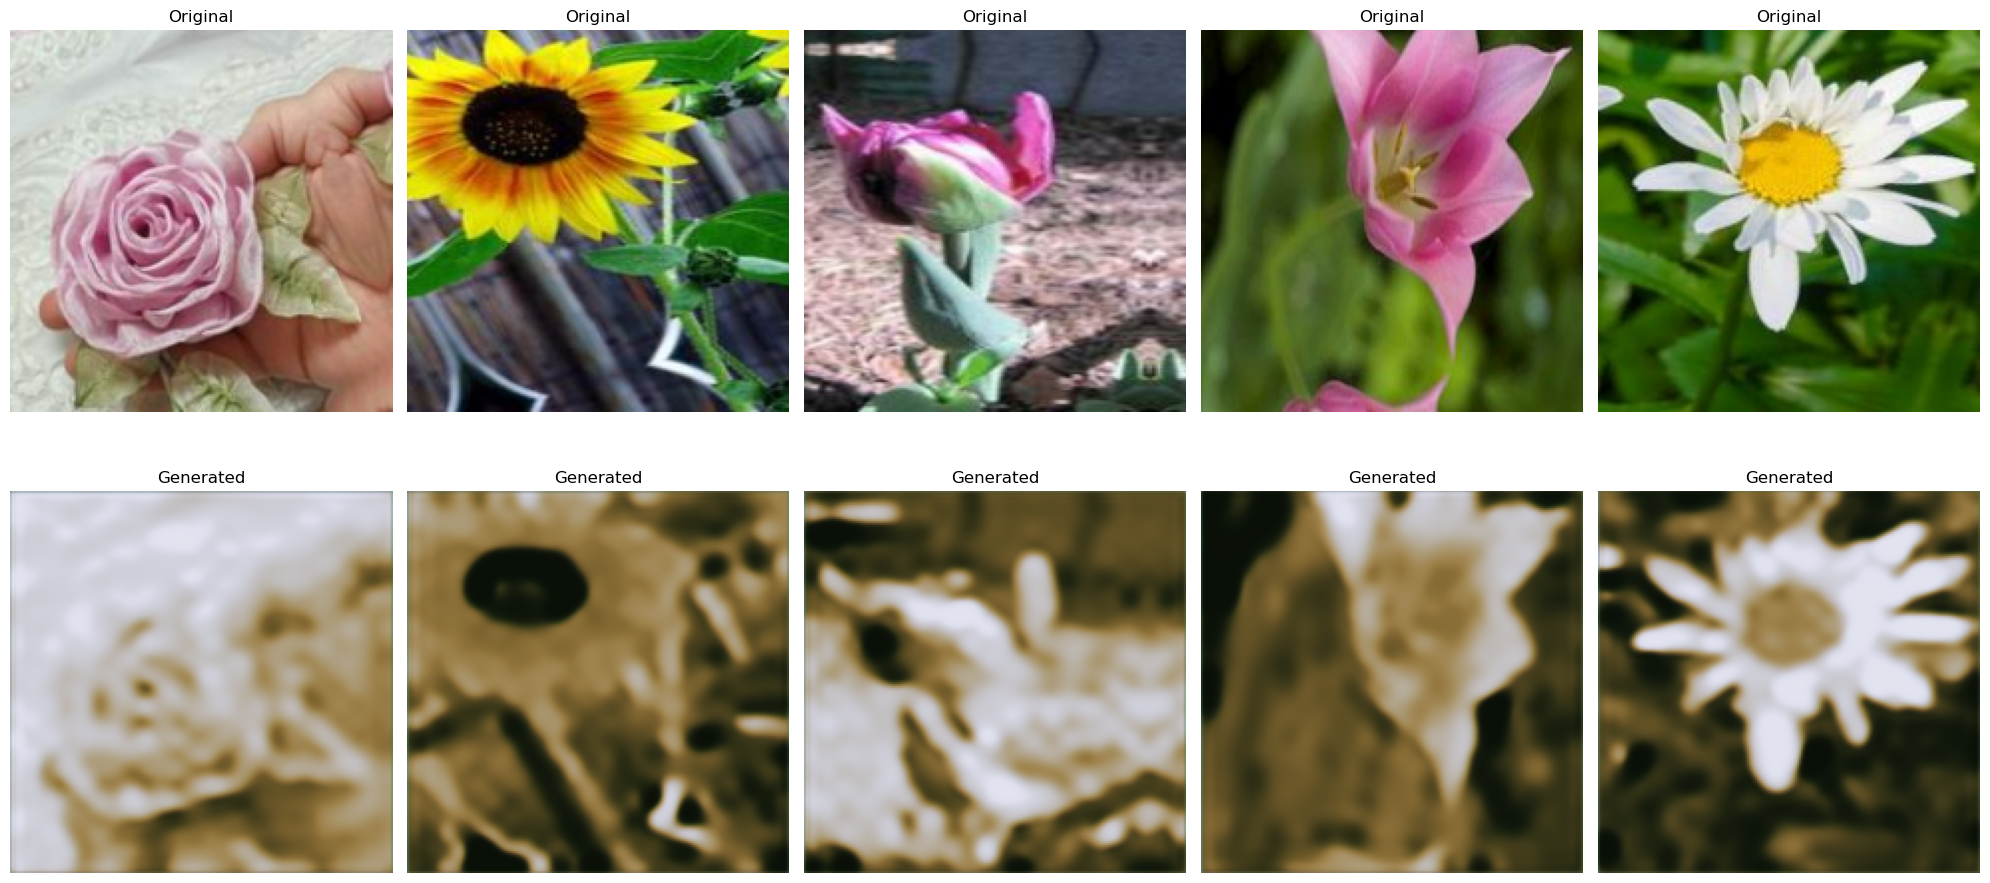

Found 37728 files belonging to 5 classes.


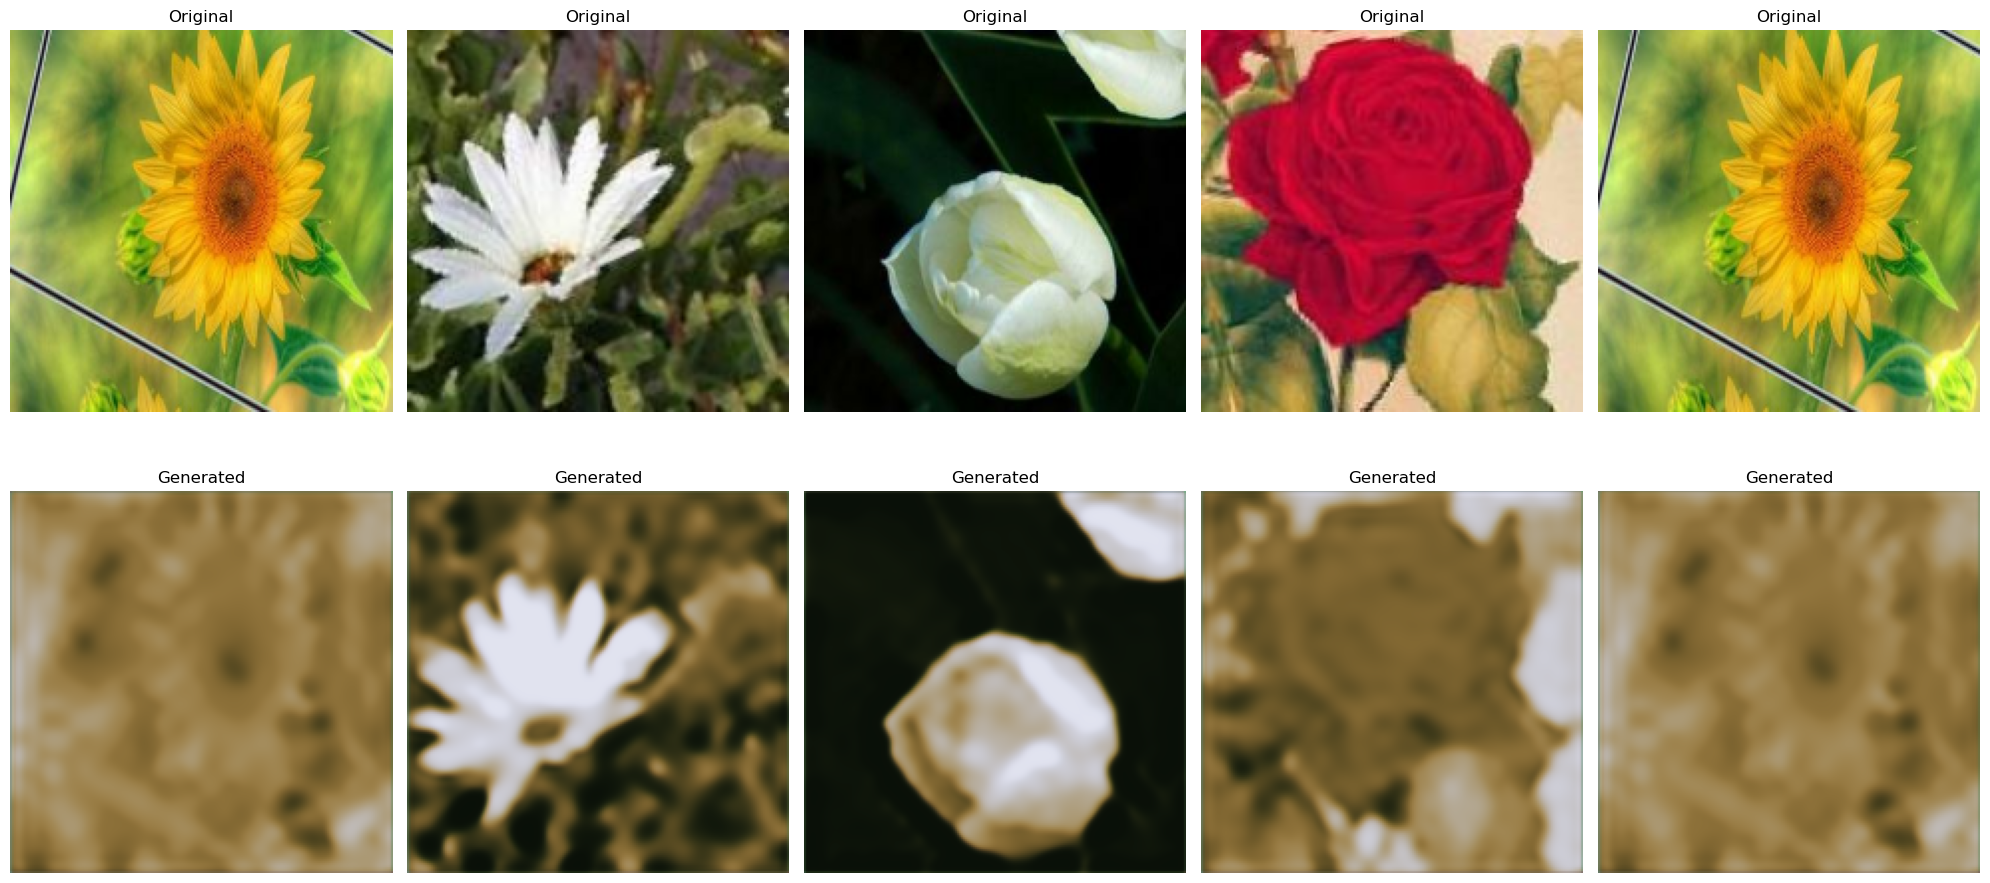

In [37]:
import matplotlib.pyplot as plt
from random import randint
import numpy as np

data = np.array([i[0][0] for count, i in enumerate(init_data_with_batch_size(1))
                 if count < 16])
generated_images = vae.predict(data, verbose=False)

num_images = 5

plt.figure(figsize=(20, 10))

for _ in range(num_images):
    random_num = randint(0, 16-1)

    # Оригинальное изображение
    plt.subplot(2, num_images, _ + 1)
    plt.imshow(data[random_num])
    plt.title("Original")
    plt.axis("off")

    # Сгенерированное изображение
    plt.subplot(2, num_images, _ + num_images + 1)
    plt.imshow(generated_images[random_num])
    plt.title("Generated")
    plt.axis("off")
plt.tight_layout()
plt.show()

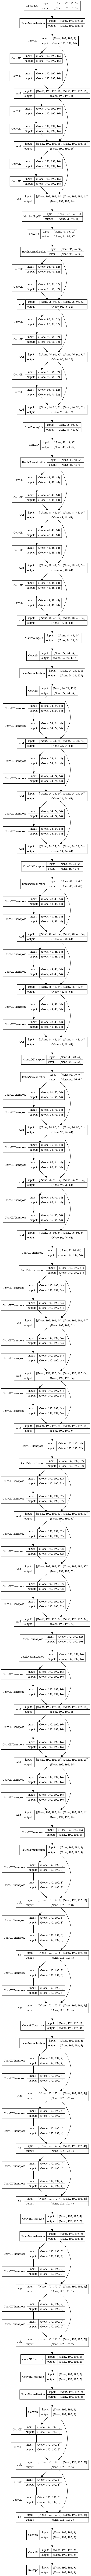

In [38]:
"""Выводим Архитектуру"""
img_file = "architecture.png"
tf.keras.utils.plot_model(vae, to_file=img_file, show_shapes=True, show_layer_names=False)

In [7]:
# from keras.models import load_model, save_model
# # save_model(vae, "best")
# vae = load_model("best")